In [1]:
%load_ext autoreload
%autoreload 2

10-Aug-19 13:47:37 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


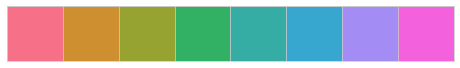

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import logging

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
np.set_printoptions(precision=4)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("husl", 8))
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.ERROR)

 

In [3]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import f1_score

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [5]:
def extended_describe(dataframe):
    extended_describe_df= dataframe.describe(include='all').T 
    extended_describe_df['null_count']= dataframe.shape[0]- extended_describe_df['count']
    return extended_describe_df 

In [6]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

In [7]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [8]:
supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
train_y = train_dataset[RESPONSE]

In [9]:
#pandas_profiling.ProfileReport(train_dataset)

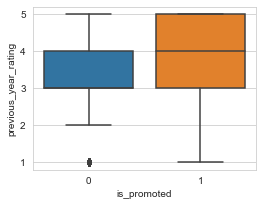

In [10]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(y="previous_year_rating", x="is_promoted", data=train_dataset)

In [11]:
train_dataset[['previous_year_rating','is_promoted']].groupby(['is_promoted']).describe()

previous_year_rating                                             
                           count      mean       std  min  25%  50%  75%  max
is_promoted                                                                  
0                        46355.0  3.267911  1.260327  1.0  3.0  3.0  4.0  5.0
1                         4329.0  3.986140  1.052149  1.0  3.0  4.0  5.0  5.0

In [12]:
extended_describe(train_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,54808,NaN,NaN,NaN,39195.8,22586.6,1,19669.8,39225.5,58730.5,78298,0
department,54808,9,Sales & Marketing,16840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,54808,34,region_2,12343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,52399,3,Bachelor's,36669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2409
gender,54808,2,m,38496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,54808,3,other,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,54808,NaN,NaN,NaN,1.25301,0.609264,1,1,1,1,10,0
age,54808,NaN,NaN,NaN,34.8039,7.66017,20,29,33,39,60,0
previous_year_rating,50684,NaN,NaN,NaN,3.32926,1.25999,1,3,3,4,5,4124
length_of_service,54808,NaN,NaN,NaN,5.86551,4.26509,1,3,5,7,37,0


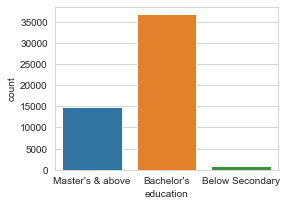

In [13]:
plt.figure(figsize=(4,3))
ax = sns.countplot(x="education",data=train_dataset)

In [14]:
extended_describe(train_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,54808,NaN,NaN,NaN,39195.8,22586.6,1,19669.8,39225.5,58730.5,78298,0
department,54808,9,Sales & Marketing,16840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,54808,34,region_2,12343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,52399,3,Bachelor's,36669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2409
gender,54808,2,m,38496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,54808,3,other,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,54808,NaN,NaN,NaN,1.25301,0.609264,1,1,1,1,10,0
age,54808,NaN,NaN,NaN,34.8039,7.66017,20,29,33,39,60,0
previous_year_rating,50684,NaN,NaN,NaN,3.32926,1.25999,1,3,3,4,5,4124
length_of_service,54808,NaN,NaN,NaN,5.86551,4.26509,1,3,5,7,37,0


In [15]:
train_rating_by_region_department =train_dataset.groupby(['region','department']) ['previous_year_rating'].median()

In [16]:
test_rating_by_region_department = test_dataset.groupby(['region','department'])['previous_year_rating'].median()

In [17]:
def impute_rating(row):
    return train_rating_by_region_department[row['region'],row['department']]

In [18]:
train_dataset['previous_year_rating'].fillna(train_dataset[train_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)
test_dataset['previous_year_rating'].fillna(test_dataset[test_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [19]:
train_education_mode = train_dataset.groupby(['department']).agg({'education':lambda x: x.value_counts(dropna=False).index[0]}).reset_index()

In [20]:
train_dataset['education'].fillna("Bachelor's",inplace=True)
test_dataset['education'].fillna("Bachelor's",inplace=True)

In [21]:
extended_describe(train_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,54808,NaN,NaN,NaN,39195.8,22586.6,1,19669.8,39225.5,58730.5,78298,0
department,54808,9,Sales & Marketing,16840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,54808,34,region_2,12343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,54808,3,Bachelor's,39078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
gender,54808,2,m,38496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,54808,3,other,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,54808,NaN,NaN,NaN,1.25301,0.609264,1,1,1,1,10,0
age,54808,NaN,NaN,NaN,34.8039,7.66017,20,29,33,39,60,0
previous_year_rating,54808,NaN,NaN,NaN,3.32132,1.21753,1,3,3,4,5,0
length_of_service,54808,NaN,NaN,NaN,5.86551,4.26509,1,3,5,7,37,0


In [22]:
extended_describe(test_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,23490,NaN,NaN,NaN,39041.4,22640.8,3,19370.2,38963.5,58690,78295,0
department,23490,9,Sales & Marketing,7315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,23490,34,region_2,5299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,23490,3,Bachelor's,16612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
gender,23490,2,m,16596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,23490,3,other,13078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,23490,NaN,NaN,NaN,1.25424,0.60091,1,1,1,1,9,0
age,23490,NaN,NaN,NaN,34.7829,7.67949,20,29,33,39,60,0
previous_year_rating,23490,NaN,NaN,NaN,3.32929,1.2195,1,3,3,4,5,0
length_of_service,23490,NaN,NaN,NaN,5.81039,4.20792,1,3,5,7,34,0


In [23]:
full_dataset = pd.concat(objs=[train_dataset,test_dataset],axis=0,sort =True).reset_index(drop=True) 

In [24]:
department_encoding = {'R&D':1,'Legal':1,'HR':2,'Finance':2,
                       'Analytics':3,'Technology':4,'Procurement':4,
                       'Operations':5,'Sales & Marketing':5}

education_encoding = {"Bachelor's":3,"Master's & above":2,'Below Secondary':1}

gender_encoding = {'f':0,'m':1}
recruitment_channel_encoding = {'other':3,'sourcing':2, 'referred':1}


In [25]:
full_dataset['gender'] =full_dataset['gender'].map(gender_encoding)
full_dataset['recruitment_channel'] =full_dataset['recruitment_channel'].map(recruitment_channel_encoding)
full_dataset['department'] =full_dataset['department'].map(department_encoding)
full_dataset['education'] =full_dataset['education'].map(education_encoding)
full_dataset['previous_year_rating'] =full_dataset['previous_year_rating'].astype(int)

In [26]:
full_dataset = pd.get_dummies(full_dataset, columns = ["region"],prefix="d",drop_first = True)
train_dataset['previous_year_rating'] =train_dataset['previous_year_rating'].astype(int)
full_dataset.rename(columns={'KPIs_met >80%': 'KPIs_met_GT_80', 'awards_won?': 'awards_won'}, inplace=True)

In [27]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78298 entries, 0 to 78297
Data columns (total 46 columns):
KPIs_met_GT_80          78298 non-null int64
age                     78298 non-null int64
avg_training_score      78298 non-null int64
awards_won              78298 non-null int64
department              78298 non-null int64
education               78298 non-null int64
employee_id             78298 non-null int64
gender                  78298 non-null int64
is_promoted             54808 non-null float64
length_of_service       78298 non-null int64
no_of_trainings         78298 non-null int64
previous_year_rating    78298 non-null int32
recruitment_channel     78298 non-null int64
d_region_10             78298 non-null uint8
d_region_11             78298 non-null uint8
d_region_12             78298 non-null uint8
d_region_13             78298 non-null uint8
d_region_14             78298 non-null uint8
d_region_15             78298 non-null uint8
d_region_16             78298 non-

In [28]:
full_dataset.head()

,KPIs_met_GT_80,age,avg_training_score,awards_won,department,education,employee_id,gender,is_promoted,length_of_service,...,d_region_31,d_region_32,d_region_33,d_region_34,d_region_4,d_region_5,d_region_6,d_region_7,d_region_8,d_region_9
0,1,35,49,0,5,2,65438,0,0.0,8,...,0,0,0,0,0,0,0,1,0,0
1,0,30,60,0,5,3,65141,1,0.0,4,...,0,0,0,0,0,0,0,0,0,0
2,0,34,50,0,5,3,7513,1,0.0,7,...,0,0,0,0,0,0,0,0,0,0
3,0,39,50,0,5,3,2542,1,0.0,10,...,0,0,0,0,0,0,0,0,0,0
4,0,45,73,0,4,3,48945,1,0.0,2,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_dataset =full_dataset[full_dataset['is_promoted'].notnull()]
test_dataset  = full_dataset[full_dataset['is_promoted'].isnull()]
test_dataset_emp =test_dataset['employee_id']
train_y=full_dataset[full_dataset['is_promoted'].notnull()]['is_promoted']

full_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
train_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
test_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)


kfold = StratifiedKFold(n_splits=5)

test_size = 0.25
seed = 2

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)

In [30]:
full_dataset.columns

Index(['KPIs_met_GT_80', 'age', 'avg_training_score', 'awards_won',
       'department', 'education', 'gender', 'length_of_service',
       'no_of_trainings', 'previous_year_rating', 'd_region_10', 'd_region_11',
       'd_region_12', 'd_region_13', 'd_region_14', 'd_region_15',
       'd_region_16', 'd_region_17', 'd_region_18', 'd_region_19',
       'd_region_2', 'd_region_20', 'd_region_21', 'd_region_22',
       'd_region_23', 'd_region_24', 'd_region_25', 'd_region_26',
       'd_region_27', 'd_region_28', 'd_region_29', 'd_region_3',
       'd_region_30', 'd_region_31', 'd_region_32', 'd_region_33',
       'd_region_34', 'd_region_4', 'd_region_5', 'd_region_6', 'd_region_7',
       'd_region_8', 'd_region_9'],
      dtype='object')

In [31]:

test_size = 0.20
seed = 2

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)

In [32]:
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))
 

Accuracy: 91.972


In [33]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)

In [34]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score, confusion_matrix
# forest_params = {'max_depth': range(5,10),
#                  'max_features': ['sqrt'],
#                  'min_samples_leaf':range(1,6,1)}
# forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
#                                 random_state=17)
# forest_grid = GridSearchCV(forest, forest_params,cv=5, n_jobs=-1, verbose=True,scoring ='f1')
# forest_grid.fit(X_trainmodel, y_trainmodel)

In [35]:
import time
from scipy.stats import randint as sp_randint

In [36]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [37]:
# n_iter_search = 20
# clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
#                                 random_state=17)
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5, iid=False, verbose=10, random_state=0)

# start = time.time()
# random_search.fit(X_trainmodel, y_trainmodel)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))
# report(random_search.cv_results_)

In [38]:
# best_forest = random_search.best_estimator_
# print("Best parameters: {}".format(random_search.best_params_))
# print("Best cross-validation score: {:.2f}".format(random_search.best_score_))
# print("Best estimator:\n{}".format(random_search.best_estimator_))
# evaluvate_model(best_forest,X_trainmodel, y_trainmodel,X_val,y_val)
 

In [39]:

# feature extraction

def select_features_by_rf(X,y):
    model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(selected_features.shape[0],1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [40]:
# features_by_rf = select_features_by_rf(X_trainmodel,y_trainmodel)
# features = features_by_rf[features_by_rf['model_result'] > 0.0001]
# selected_features = list(features['name'].values)
# ",".join(selected_features)

In [41]:
# from yellowbrick.features import Rank1D, Rank2D 
# from yellowbrick.features import RadViz

In [42]:
# plt.figure(figsize=(5,12))
# visualizer = Rank1D(features=selected_features, algorithm='shapiro')
# visualizer.fit(X_trainmodel, y_trainmodel)                # Fit the data to the visualizer
# visualizer.transform(X_trainmodel)             # Transform the data
# visualizer.poof()     

In [43]:
Checkpoint

NameError: name 'Checkpoint' is not defined

In [44]:
X_trainmodel_copy  = X_trainmodel.copy()
X_val_copy  = X_val.copy()
test_dataset_copy  = test_dataset.copy()

In [ ]:
# X_trainmodel = X_trainmodel[selected_features]
# X_val =X_val[selected_features]
# test_dataset = test_dataset[selected_features]


In [ ]:
X_trainmodel.columns

In [45]:
from itertools import combinations
def add_interactions(X_trainmodel,X_val,test_dataset):
    feature_interactions = list(combinations(list(X_trainmodel.columns), 2))
    interact_colnames = list(X_trainmodel.columns)+['_'.join(x) for x in feature_interactions]
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    X_trainmodel = poly.fit_transform(X_trainmodel)
    X_trainmodel = pd.DataFrame(X_trainmodel)
    X_trainmodel.columns = interact_colnames
    
    X_val =poly.transform(X_val)
    X_val = pd.DataFrame(X_val)
    X_val.columns = interact_colnames
    
    test_dataset =poly.transform(test_dataset)
    test_dataset = pd.DataFrame(test_dataset)
    test_dataset.columns = interact_colnames
    
    noint_indices = [i for i,x in enumerate(list((X_trainmodel==0).all())) if x]
    xval_noint_indices = [i for i,x in enumerate(list((X_val==0).all())) if x]
    test_noint_indices = [i for i,x in enumerate(list((test_dataset==0).all())) if x]
    
    X_trainmodel = X_trainmodel.drop(X_trainmodel.columns[noint_indices], axis=1)
    
    X_val = X_val.drop(X_val.columns[xval_noint_indices], axis=1)
    
    test_dataset =  test_dataset.drop(test_dataset.columns[test_noint_indices], axis=1)
    return X_trainmodel,X_val,test_dataset

In [46]:
X_trainmodel,X_val,test_dataset = add_interactions(X_trainmodel,X_val,test_dataset)

In [48]:
display(X_trainmodel.shape)
display(X_val.shape)
display(test_dataset.shape)

(43846, 417)

(10962, 417)

(23490, 417)

In [ ]:
# polynomial_features= PolynomialFeatures(degree=2,interaction_only=True ,include_bias =False)
# X_trainmodel = polynomial_features.fit_transform(X_trainmodel)
# X_val = polynomial_features.fit_transform(X_val)
# test_dataset = polynomial_features.fit_transform(test_dataset)

In [49]:
from sklearn.linear_model  import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 92.529


In [50]:
param_dist = {"max_depth": [ None],
              "max_features": ['sqrt'],
              "min_samples_split": sp_randint(5, 11),
              "bootstrap": [True, False],
              "criterion": ["entropy"]}

In [51]:
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 92.529


In [53]:
n_iter_search = 20
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, 
                                random_state=17)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, verbose=10, random_state=0)

start = time.time()
random_search.fit(X_trainmodel, y_trainmodel)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.930, total=  13.6s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.928, total=   6.2s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.7s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.930, total=   6.0s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.8s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.933, total=   5.8s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.6s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.930, total=   6.5s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8, score=0.929, total=   8.8s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.9s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8, score=0.925, total=  10.5s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   57.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8, score=0.929, total=   9.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8, score=0.930, total=  14.6s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=8, min_samples_split=8, score=0.928, total=  14.8s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8, score=0.928, total=  14.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8, score=0.925, total=  12.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8, score=0.928, total=   8.9s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=6, min_samples_split=8, score=0.930, total=   8.8s
[CV] bootstrap

[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=8, score=0.929, total=   7.7s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=8 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=8, score=0.924, total=   7.5s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7, score=0.926, total=   7.9s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7, score=0.923, total=   7.6s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=7, score=0.927, total=   7.8s
[CV] bootstrap

[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7, score=0.928, total=   9.0s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7, score=0.931, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7, score=0.934, total=   8.2s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=9, min_samples_split=7, score=0.930, total=   8.7s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=5, min_samples_split=9 
[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=5, min_samples_split=9, score=0.928, total=   8.0s
[CV] bootstrap=True, cr

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 15.0min finished


RandomizedSearchCV took 907.49 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.930 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.930 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.930 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_split': 9}



Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 7}
Best cross-validation score: 0.93
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=17, verbose=0,
                       warm_start=False)


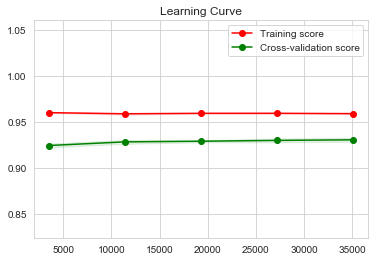

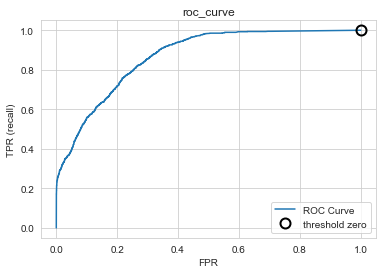

Classification report
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     10015
         1.0       0.85      0.25      0.39       947

    accuracy                           0.93     10962
   macro avg       0.89      0.62      0.68     10962
weighted avg       0.93      0.93      0.91     10962

Confusion matrix
[[9974   41]
 [ 707  240]]


In [54]:
best_forest = random_search.best_estimator_
print("Best parameters: {}".format(random_search.best_params_))
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))
print("Best estimator:\n{}".format(random_search.best_estimator_))
evaluvate_model(best_forest,X_trainmodel, y_trainmodel,X_val,y_val)

In [ ]:
#Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 6}
#Best cross-validation score: 0.93
#Best estimator:
#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#                       max_depth=None, max_features=10, max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=6,
#                       min_weight_fraction_leaf=0.0, n_estimators=100,
#                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
#                       warm_start=False)
#{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 7}
Checker


In [55]:
xgbclf= XGBClassifier(n_estimators=50, silent=False)
xgbclf.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

#best_model ,result = test_classifier(xgbclf,X_trainmodel,y_trainmodel,kfold)
print(xgbclf)


[14:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

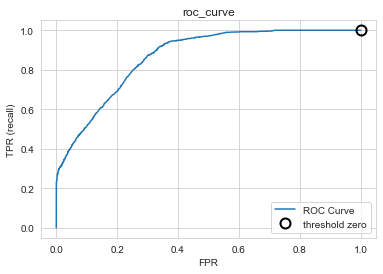

In [56]:
plot_roc(X_val,y_val,xgbclf)

In [57]:
def calc_f1_score(predictions, y_test):
    labels = y_test.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in predictions]
    return 'f1',f1_score(labels,y_bin)

In [62]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
           
          #"subsample": 0.5,
          'colsample_bylevel': 0.9,
          'gamma': 0.02,
          'min_child_weight':5,
          "silent": 1,
          'scale_pos_weight':2,
          }

num_boost_round =50

In [63]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_f1_score, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.065479	eval-merror:0.068145	train-f1:0.393152	eval-f1:0.380083
Multiple eval metrics have been passed: 'eval-f1' will be used for early stopping.

Will train until eval-f1 hasn't improved in 50 rounds.
[1]	train-merror:0.06557	eval-merror:0.067688	train-f1:0.389985	eval-f1:0.387789
[2]	train-merror:0.065388	eval-merror:0.067323	train-f1:0.394509	eval-f1:0.392092
[3]	train-merror:0.065388	eval-merror:0.067415	train-f1:0.394509	eval-f1:0.390767
[4]	train-merror:0.065251	eval-merror:0.067415	train-f1:0.395776	eval-f1:0.389761
[5]	train-merror:0.065251	eval-merror:0.067323	train-f1:0.395521	eval-f1:0.391089
[6]	train-merror:0.065297	eval-merror:0.067323	train-f1:0.394074	eval-f1:0.391089
[7]	train-merror:0.065434	eval-merror:0.067232	train-f1:0.391774	eval-f1:0.390405
[8]	train-merror:0.065388	eval-merror:0.067323	train-f1:0.391424	eval-f1:0.389073
[9]	train-merror:0.065228	eval-merror:0.067415	train-f1:0.392265	eval-f1:0.387738
[10]	train-merror:0.

In [ ]:
test_y  =gbm.predict(xgb.DMatrix(test_dataset))

In [ ]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':test_y}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="predictions/HR_Analytics_XgBoostV1_"+timestamp+"_out.csv"
#submission.to_csv(filename,index=False)

In [ ]:
submission.to_csv(filename,index=False)

In [ ]:
#.472